# CSC4210 Computer Vision Final Project

This notebook implements the core computer-vision pipeline for my CSC4210 final project using the SunFounder PiCar-X v2. It demonstrates how to:

1. **Capture frames** from an upgraded IMX708-based camera using Picamera2  
2. **Convert and preprocess** each frame (RGB -> BGR, RGB -> HSV, Gaussian blur)  
3. **Run Canny edge detection** and **Hough line transforms** to extract and visualize lane markings  
4. **Log performance metrics** and save intermediate results for documentation  

Use the cells below to iterate on parameter tuning, verify each processing stage, and build toward autonomous path planning on the PiCar-X.  


*Note:* Use Picamera2 for frame capture because OpenCV’s VideoCapture cannot reliably grab frames from the Pi’s CSI camera under the libcamera/V4L2 stack (per Picamera2 and OpenCV documentation)

Imports:

* Pi Camera v2.x
* OpenCV
* NumPy
* Time
* IPython's Display and Image

In [ ]:
# Boilerplate code required to run the examples in this notebook
from picamera2 import Picamera2
import cv2 as cv
import numpy as np
import time
from IPython.display import display, Image

# Initialize Picamera2 with the IMX708's native resolution
picam2 = Picamera2()
preview_config = picam2.create_still_configuration(main={"size": (3280, 2464)}) # TODO: adjust resolution for performance?
picam2.configure(preview_config)

# Start the camera and warm-up (e.g. automatic white balance, exposure, etc.)
# The NULL preview is in fact started automatically whenever the camera
# system is started (picam2.start()) if no preview configuration is provided.
picam2.start() # Start the camera
time.sleep(2) # Allow time for the camera to adjust

[3:29:18.947159763] [2554]  INFO Camera camera.cpp:1205 configuring streams: (0) 3280x2464-BGR888 (1) 4608x2592-BGGR_PISP_COMP1
[3:29:18.947342854] [3741]  INFO RPI pisp.cpp:1483 Sensor: /base/axi/pcie@1000120000/rp1/i2c@80000/imx708@1a - Selected sensor format: 4608x2592-SBGGR10_1X10 - Selected CFE format: 4608x2592-PC1B


## RGB → BGR Conversion

Picamera2 returns images in **RGB** channel order, but OpenCV’s functions (e.g. `cv.Canny`, `cv.cvtColor`, `cv.imencode`) expect **BGR** channel order by default. Feeding an RGB image directly into OpenCV will swap the red and blue channels, causing an unnatural blue cast.

To correct this, we convert with:

```python
bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)


In [177]:
# Utility: grab a frame and convert to proper BGR for OpenCV
def grab_bgr_frame():
    rgb = picam2.capture_array()              # RGB
    bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)  # → BGR
    return bgr

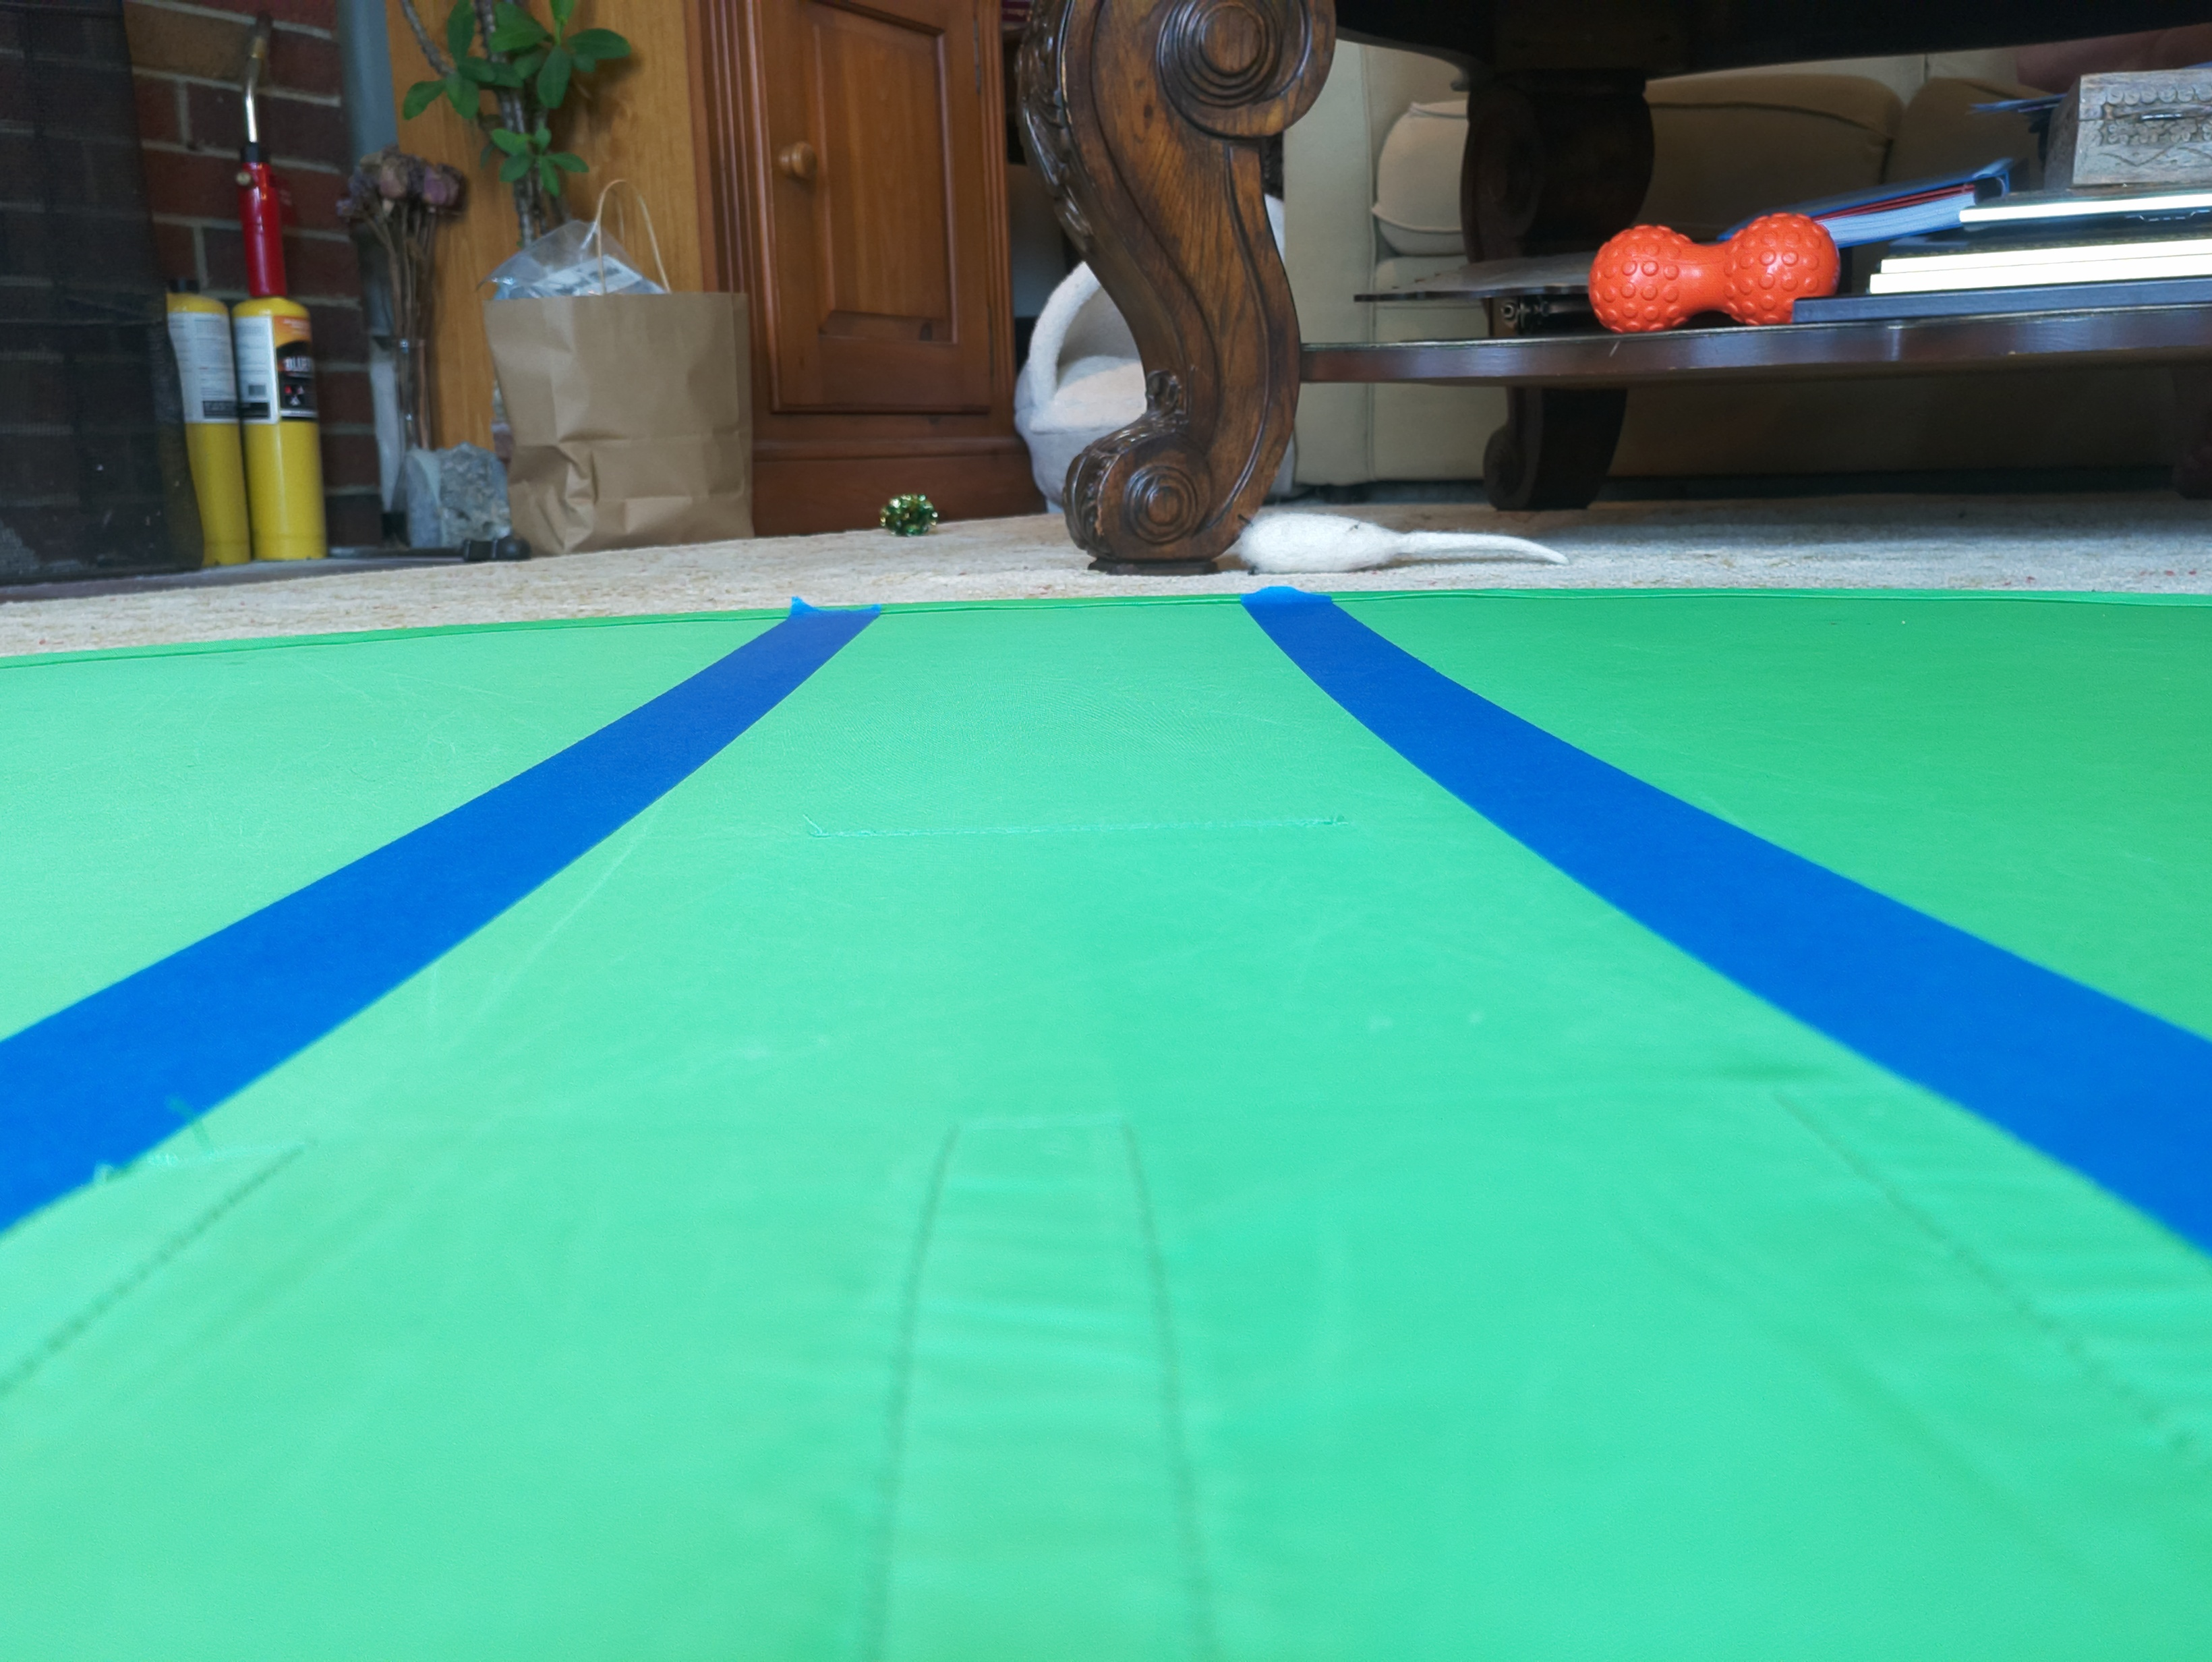

Frame shape: (2464, 3280, 3)


In [162]:
# [2] Experiment: raw frame + inline display
frame = grab_bgr_frame()
frame_small = cv.resize(frame, (640, 480))  # or (1024, 768) for 4:3
_, buf = cv.imencode('.jpg', frame)
display(Image(data=buf.tobytes()))
print("Frame shape:", frame.shape)

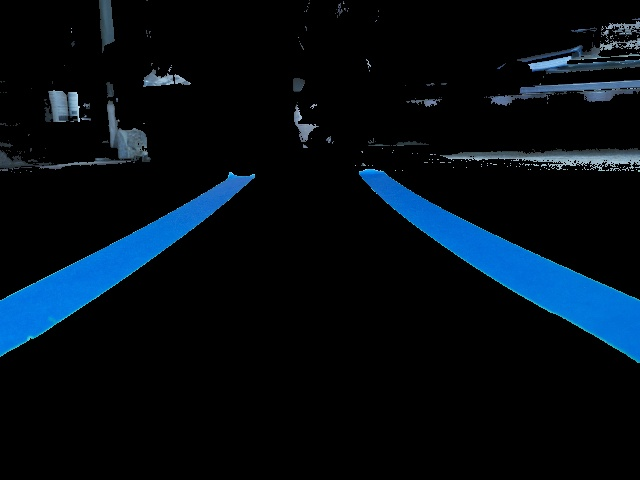

In [171]:
# Focus on the blue painter's tape by converting BGR to HSV and thresholding
# with inRange and bitwise operations
# Ref: docs.opencv.org/4.x/d3/dc1/group__imgproc__color__conversions.html

# Convert BGR to HSV
hsv = cv.cvtColor(frame_small, cv.COLOR_BGR2HSV)

# Define the lower and upper bounds for the blue color
# Note: the values are in HSV color space (values may
# need to be adjusted based on lighting conditions or
# add an LED light source to the camera)
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([110, 255, 255])

# Threshold the HSV image to get only blue colors and
# create a bitmask
# Note: the mask is a binary image where the blue
# pixels are white (255) and the rest are black (0)
# The mask is the same size as the original image
mask = cv.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image for demonstration
blueroad = cv.bitwise_and(frame_small, frame_small, mask=mask)
_, buf = cv.imencode('.jpg', blueroad)
display(Image(data=buf.tobytes()))



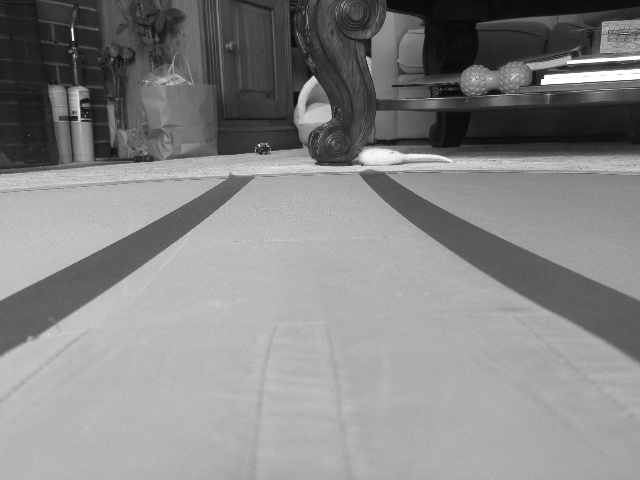

Gray shape: (480, 640)


In [172]:
# %% [3] Experiment: convert to grayscale and display
gray = cv.cvtColor(frame_small, cv.COLOR_BGR2GRAY)
_, buf2 = cv.imencode('.jpg', gray)
display(Image(data=buf2.tobytes()))
print("Gray shape:", gray.shape)

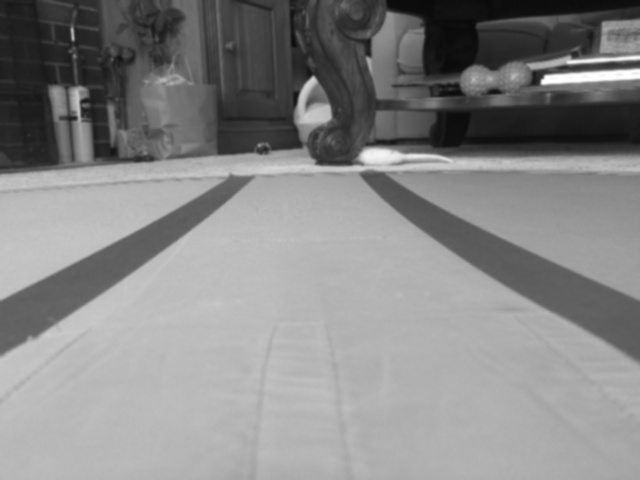

In [152]:
# %% [4] Experiment: apply Gaussian blur
blur = cv.GaussianBlur(gray, (5,5), 0)
_, buf3 = cv.imencode('.jpg', blur)
display(Image(data=buf3.tobytes()))

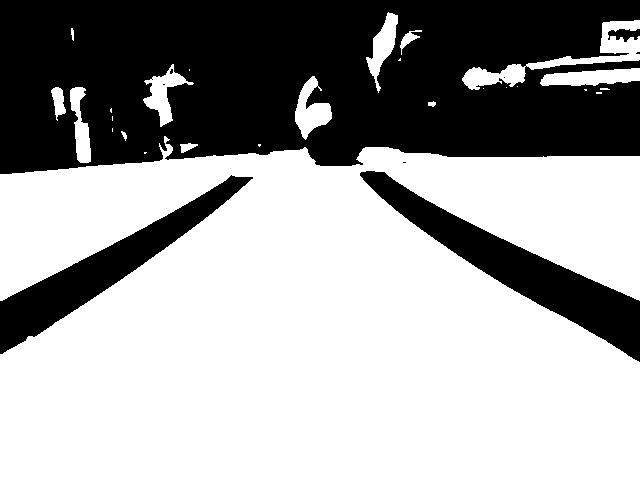

In [153]:
blur = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
_, buf4 = cv.imencode('.jpg', blur)
display(Image(data=buf4.tobytes()))

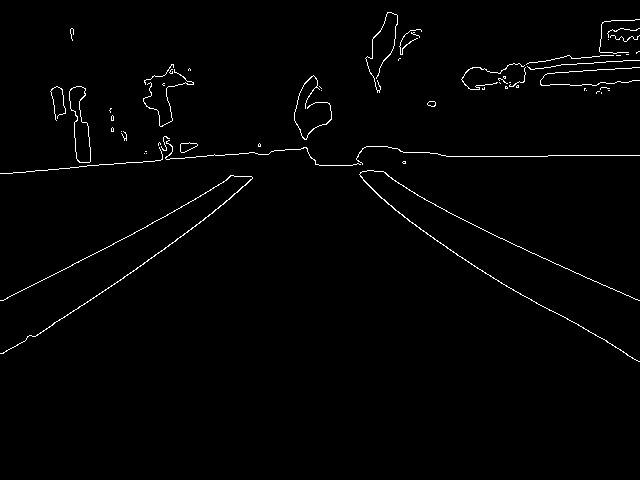

In [154]:
# %% [5] Experiment: Canny edge detection
# thresholds 50 and 150 per OpenCV tutorial
edges = cv.Canny(blur, 80, 150)
_, buf4 = cv.imencode('.jpg', edges)
display(Image(data=buf4.tobytes()))

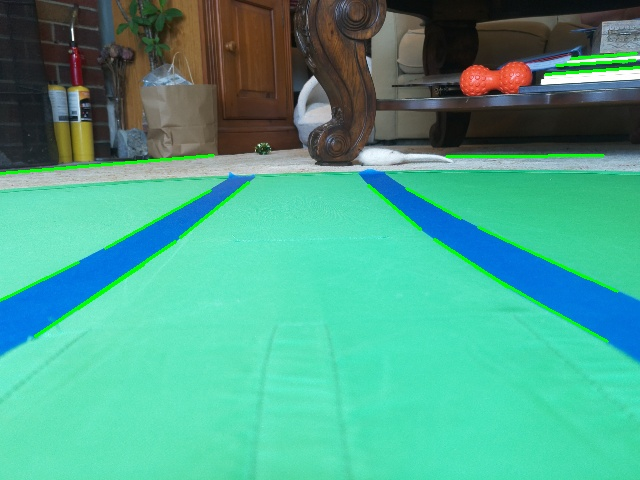

In [155]:
# %% [6] (Stretch) Hough Line Transform
lines = cv.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
vis = frame_small.copy()
if lines is not None:
    for x1,y1,x2,y2 in lines[:,0]:
        cv.line(vis, (x1,y1), (x2,y2), (0,255,0), 2)
_, buf5 = cv.imencode('.jpg', vis)
display(Image(data=buf5.tobytes()))

In [175]:
# close the camera
picam2.close()

# close the OpenCV window
cv.destroyAllWindows()